# 夏休み課題
[レポートリンク](https://docs.google.com/document/d/1dhwxJUNEezEtucHkjEleQRjPS92ktL3cK54MWFshenE/edit?usp=sharing)

## 1 まずは元データを眺めて見る

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import japanize_matplotlib
import cv2
import glob
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import itertools
import seaborn as sns

### 1-1 画像を表示
brokenとproperでは画像内の米粒の大きさが異なりそう

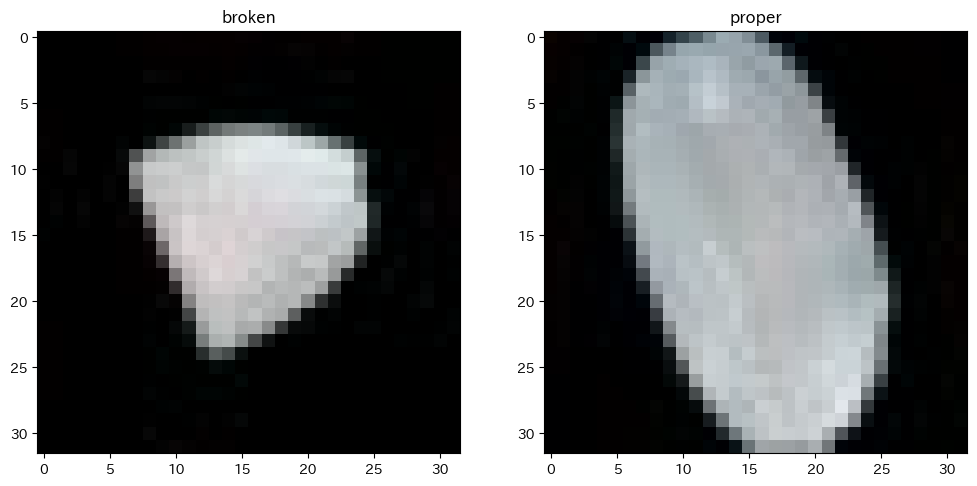

In [11]:
broken_path = "school/train/broken/287.jpg"
proper_path = "school/train/proper/181.jpg"

broken = cv2.imread(broken_path)
proper = cv2.imread(proper_path)

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_title("broken")
ax2.set_title("proper")

ax1.imshow(broken)
ax2.imshow(proper)
plt.show()

### 1-2 画像の情報を表示

In [12]:
print(broken.shape)
print(type(broken))
print(np.amax(broken), np.amin(broken))

print(proper.shape)
print(type(proper))
print(np.amax(proper), np.amin(proper))

(32, 32, 3)
<class 'numpy.ndarray'>
236 0
(32, 32, 3)
<class 'numpy.ndarray'>
236 0


## 2 brokenとproperの全データの米粒の大きさを取得し、比較したい

### 2-3 二値化を使って米粒と背景を分離する
しきい値はモード法を使ってみる

#### 2-3-1 二値化する際に使用するしきい値を探すために濃度ヒストグラムを表示
濃度ヒストグラムを見ると、0と150付近が山になっている

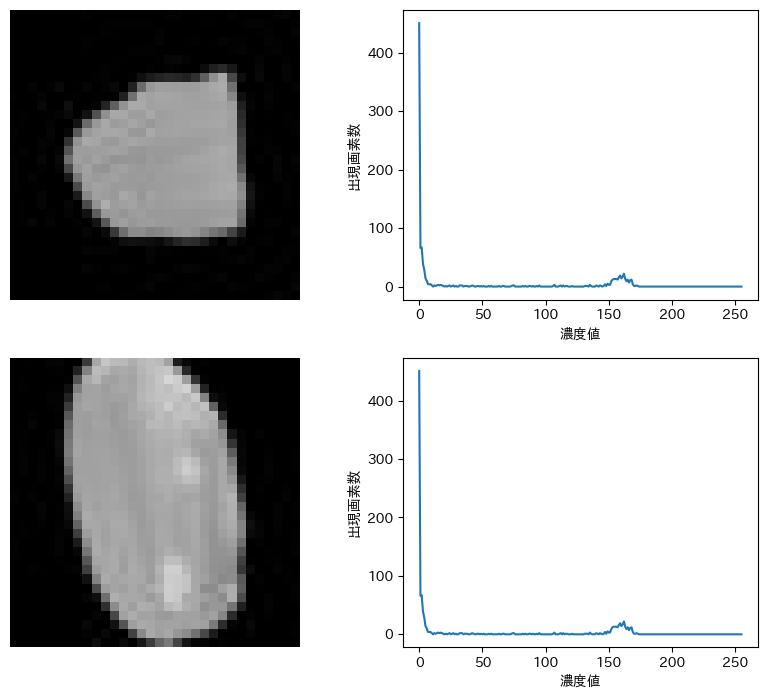

In [13]:
broken_path = "school/train/broken/155.jpg"
hist_broken = cv2.imread(broken_path, cv2.IMREAD_GRAYSCALE)
proper_path = "school/train/proper/12.jpg"
hist_proper = cv2.imread(proper_path, cv2.IMREAD_GRAYSCALE)

hist_broken_cv = cv2.calcHist([hist_broken], [0], None, [256], [0, 256])
hist_proper_cv = cv2.calcHist([hist_broken], [0], None, [256], [0, 256])

plt.rcParams["figure.figsize"] = [12, 7.5]
title = "brokenとproperの濃度ヒストグラムを表示"
fig = plt.figure(title)
plt.subplots_adjust(left=0.35, right=1, bottom=0.10, top=0.95)
plt.subplot(221)
plt.imshow(hist_broken, vmin=0, vmax=255, cmap="gray")
plt.axis("off")
plt.subplot(222)
plt.xlabel("濃度値")
plt.ylabel('出現画素数')
plt.plot(hist_broken_cv)

plt.subplot(223)
plt.imshow(hist_proper, vmin=0, vmax=255, cmap="gray")
plt.axis("off")
plt.subplot(224)
plt.xlabel("濃度値")
plt.ylabel('出現画素数')
plt.plot(hist_proper_cv)
plt.show()

#### 2-3-2 150をしきい値として二値化

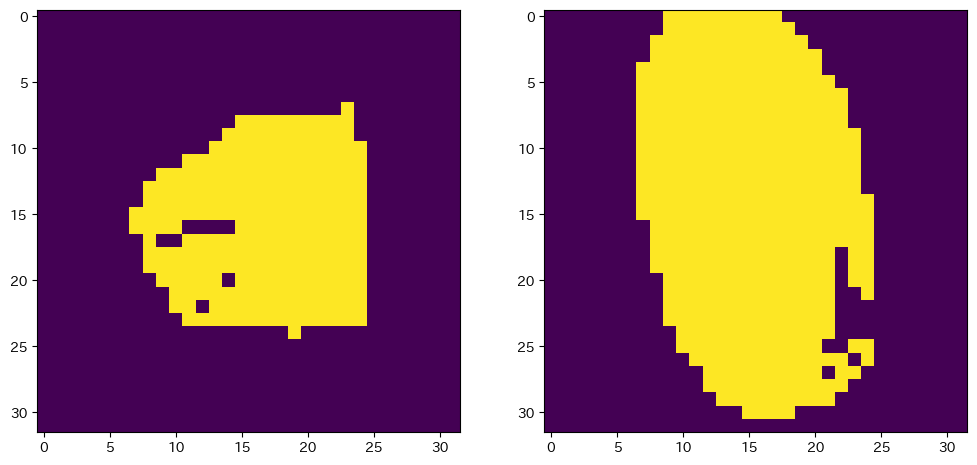

In [14]:
broken_path = "school/train/broken/155.jpg"
binary_broken = cv2.imread(broken_path, cv2.IMREAD_GRAYSCALE)
broken_value, broken_img = cv2.threshold(binary_broken, 150, 255, cv2.THRESH_BINARY)

proper_path = "school/train/proper/12.jpg"
binary_proper = cv2.imread(proper_path, cv2.IMREAD_GRAYSCALE)
proper_value, proper_img = cv2.threshold(binary_proper, 150, 255, cv2.THRESH_BINARY)

fig = plt.figure()
ax1 = plt.subplot(121)
ax1.imshow(broken_img)
ax2 = plt.subplot(122)
ax2.imshow(proper_img)
plt.show()

### 2-4 米粒の大きさを取得

In [32]:

def get_rice_size(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    _, binary_img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
    rice_size = cv2.countNonZero(binary_img)
    return rice_size

broken_rice_size = get_rice_size("school/train/broken/150.jpg")
proper_rice_size = get_rice_size("school/train/proper/12.jpg")
print(f'Brokenの米粒の大きさ {broken_rice_size}')
print(f'Properの米粒の大きさ {proper_rice_size}')

Brokenの米粒の大きさ 170
Properの米粒の大きさ 436


### 2-5 しきい値150としたときの全データの米粒のサイズを取得

In [28]:
categories_rice_size = {"broken": [], "proper": []}

for category in categories_rice_size.keys():
    img_path_list = glob.glob("school/train/" + category + "/*")
    rice_sizes = list(map(get_rice_size, img_path_list))
    categories_rice_size[category] = rice_sizes
    
print(len(categories_rice_size["broken"]))
print(len(categories_rice_size["proper"]))


231
146


### 2-5 箱ひげ図を表示
brokenとproperで明確な境界線は確認できない

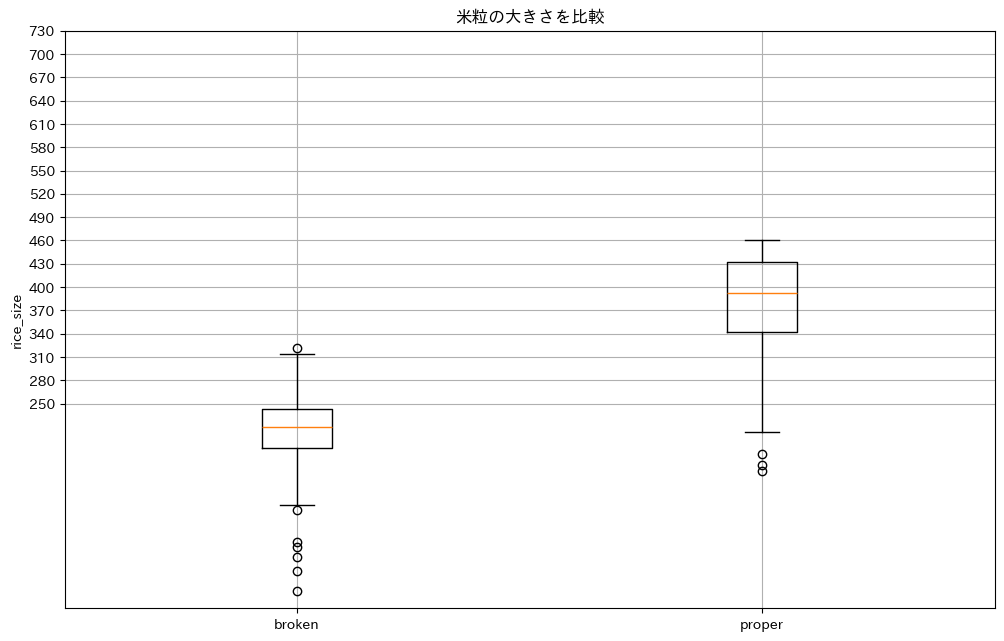

In [33]:
fig = plt.figure()
plt.subplot()
plt.boxplot(categories_rice_size.values())
plt.title("米粒の大きさを比較")
plt.xticks([1, 2], ["broken", "proper"])
plt.yticks(np.arange(250, 750, 30))
plt.ylabel("rice_size")
plt.grid()

### 2-6 二値化処理を外してグレースケール処理のみにしてみる

In [37]:
def get_rice_size(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    rice_size = cv2.countNonZero(img)
    return rice_size

broken_rice_size = get_rice_size("school/train/broken/150.jpg")
proper_rice_size = get_rice_size("school/train/proper/12.jpg")
print(f'Brokenの米粒の大きさ {broken_rice_size}')
print(f'Properの米粒の大きさ {proper_rice_size}')

Brokenの米粒の大きさ 456
Properの米粒の大きさ 699


In [38]:
categories_rice_size = {"broken": [], "proper": []}

for category in categories_rice_size.keys():
    img_path_list = glob.glob("school/train/" + category + "/*")
    rice_sizes = list(map(get_rice_size, img_path_list))
    categories_rice_size[category] = rice_sizes
    
print(len(categories_rice_size["broken"]))
print(len(categories_rice_size["proper"]))

231
146


### 2-7 箱ひげ図を表示
brokenの最大値が610でproperの最小値が630くらいなので、間をとっておおよそ米粒の大きさが620より大きければ、properそうでなければbrokenとだいたい分類可能なのではないか？

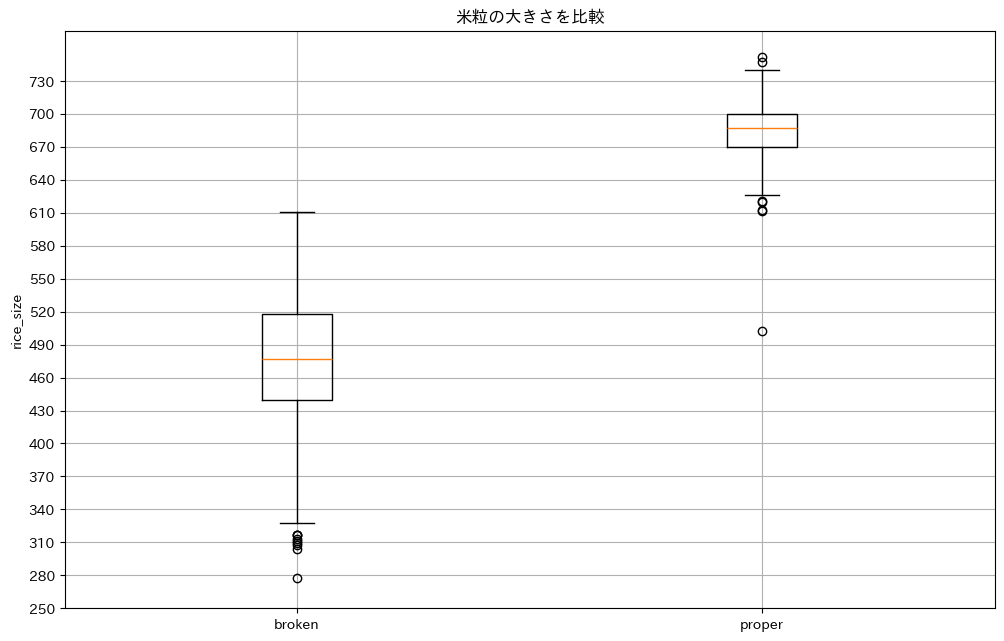

In [39]:
fig = plt.figure()
plt.subplot()
plt.boxplot(categories_rice_size.values())
plt.title("米粒の大きさを比較")
plt.xticks([1, 2], ["broken", "proper"])
plt.yticks(np.arange(250, 750, 30))
plt.ylabel("rice_size")
plt.grid()

## 3 米粒の大きさをしきい値150で分類した結果を学習用データでコンフュージョンマトリックスを表示

正解率 99.20424403183023%
適合率 100.0%
再現率 97.94520547945206%


<Axes: >

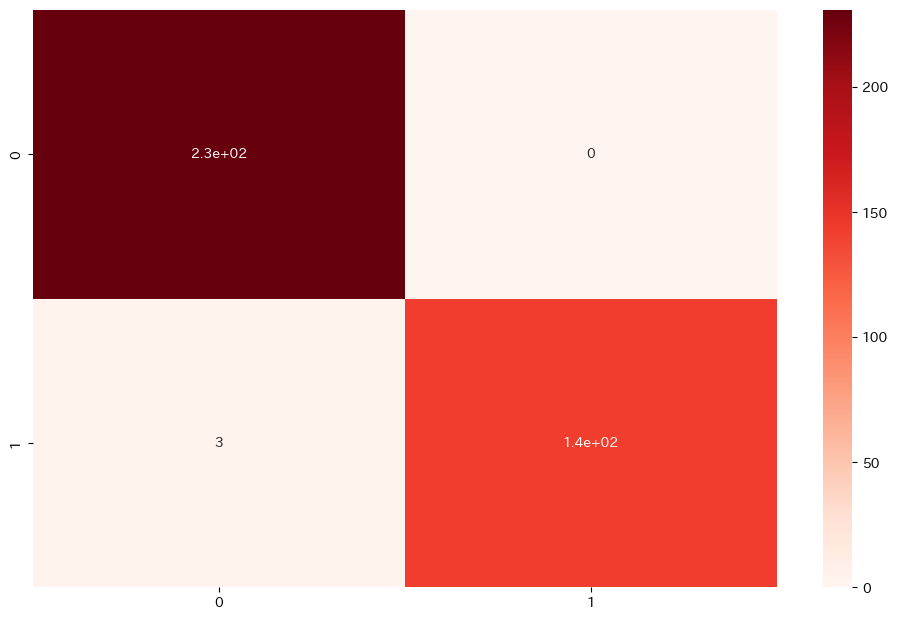

In [41]:
# コンフュージョンマトリックスを表示するために必要なy_true配列と、y_pred配列を作る
category_dict = {
    "broken": 0,
    "proper": 1
}

# broken231個を0, proper146個を1とする
y_true = np.concatenate([np.zeros(231), np.ones(146)])
y_pred = []

for category in category_dict.keys():
    img_path_list = glob.glob("school/train/" + category + "/*")
    rice_sizes = list(map(get_rice_size, img_path_list))
    y_pred.append([0 if rice_size < 620 else 1 for rice_size in rice_sizes])

y_pred = np.array(list(itertools.chain.from_iterable(y_pred))).flatten()

cm = confusion_matrix(y_true, y_pred)

tn, fp, fn, tp = cm.flatten()
print(f"正解率 {(tn + tp) / (tn + fp + fn + tp) * 100}%")
print(f"適合率 {(tp) / (fp + tp) * 100}%")
print(f"再現率 {(tp) / (fn + tp) * 100}%")
sns.heatmap(cm, annot=True, cmap="Reds")

## 3 米粒の大きさをしきい値150で分類した結果をテスト用データでコンフュージョンマトリックスを表示

正解率 100.0%
適合率 100.0%
再現率 100.0%


<Axes: >

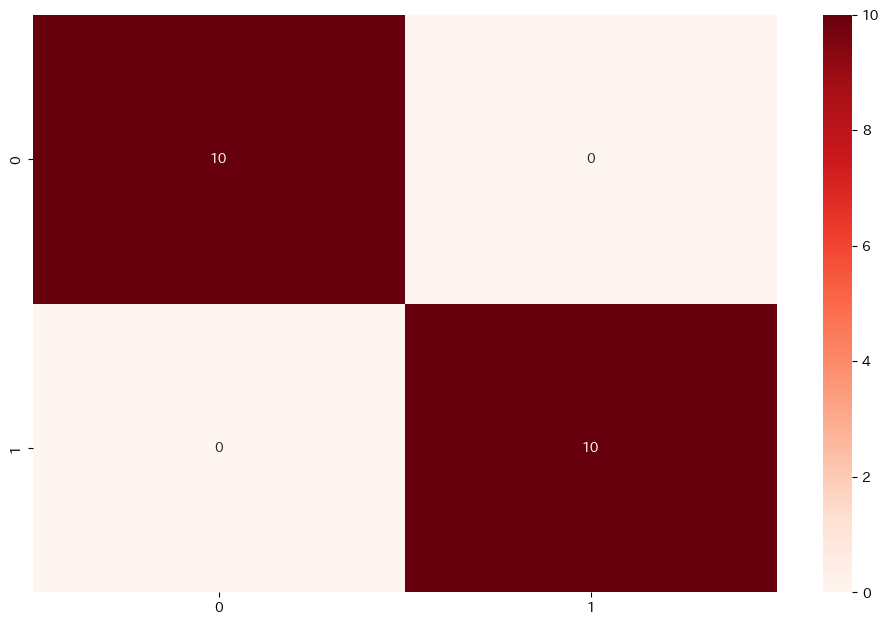

In [43]:
# コンフュージョンマトリックスを表示するために必要なy_true配列と、y_pred配列を作る
category_dict = {
    "broken": 0,
    "proper": 1
}

y_true = np.concatenate([np.zeros(10), np.ones(10)])
y_pred = []

for category in category_dict.keys():
    img_path_list = glob.glob("school/test/" + category + "/*")
    rice_sizes = list(map(get_rice_size, img_path_list))
    y_pred.append([0 if rice_size < 620 else 1 for rice_size in rice_sizes])

y_pred = np.array(list(itertools.chain.from_iterable(y_pred))).flatten()

cm = confusion_matrix(y_true, y_pred)

tn, fp, fn, tp = cm.flatten()
print(f"正解率 {(tn + tp) / (tn + fp + fn + tp) * 100}%")
print(f"適合率 {(tp) / (fp + tp) * 100}%")
print(f"再現率 {(tp) / (fn + tp) * 100}%")
sns.heatmap(cm, annot=True, cmap="Reds")